In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import cv2
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# Define constants
CLASS_NAMES = ['CaS', 'CoS', 'Gum', 'MC', 'OC', 'OLP', 'OT']
IMG_SIZE = 224
BATCH_SIZE = 32

# Set up path
base_dir = '/content/drive/MyDrive/Teeth_Dataset'
train_dir = os.path.join(base_dir, 'Training')
valid_dir = os.path.join(base_dir, 'Validation')
test_dir = os.path.join(base_dir, 'Testing')

# Verify paths and data
print("Available directories:")
print(f"Training: {os.path.exists(train_dir)}")
print(f"Validation: {os.path.exists(valid_dir)}")
print(f"Testing: {os.path.exists(test_dir)}")


Available directories:
Training: True
Validation: True
Testing: True


In [5]:
# Count images in each directory
def count_images(directory):
    counts = {}
    for class_name in CLASS_NAMES:
        class_dir = os.path.join(directory, class_name)
        if os.path.exists(class_dir):
            counts[class_name] = len(os.listdir(class_dir))
    return counts

print("\nImage counts:")
print("Training:", count_images(train_dir))
print("Validation:", count_images(valid_dir))
print("Testing:", count_images(test_dir))


Image counts:
Training: {'CaS': 480, 'CoS': 450, 'Gum': 360, 'MC': 540, 'OC': 324, 'OLP': 540, 'OT': 393}
Validation: {'CaS': 160, 'CoS': 149, 'Gum': 120, 'MC': 180, 'OC': 108, 'OLP': 180, 'OT': 131}
Testing: {'CaS': 160, 'CoS': 149, 'Gum': 120, 'MC': 180, 'OC': 108, 'OLP': 180, 'OT': 131}


In [6]:
# Create data generators
# Training generator with augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Validation and test generators (only rescaling)
valid_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Create generators for each set
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    classes=CLASS_NAMES
)

valid_generator = valid_datagen.flow_from_directory(
    valid_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    classes=CLASS_NAMES
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    classes=CLASS_NAMES
)

# Verify generators
print("Class indices:", train_generator.class_indices)
print("Steps per epoch:", len(train_generator))

Found 3087 images belonging to 7 classes.
Found 1028 images belonging to 7 classes.
Found 1028 images belonging to 7 classes.
Class indices: {'CaS': 0, 'CoS': 1, 'Gum': 2, 'MC': 3, 'OC': 4, 'OLP': 5, 'OT': 6}
Steps per epoch: 97


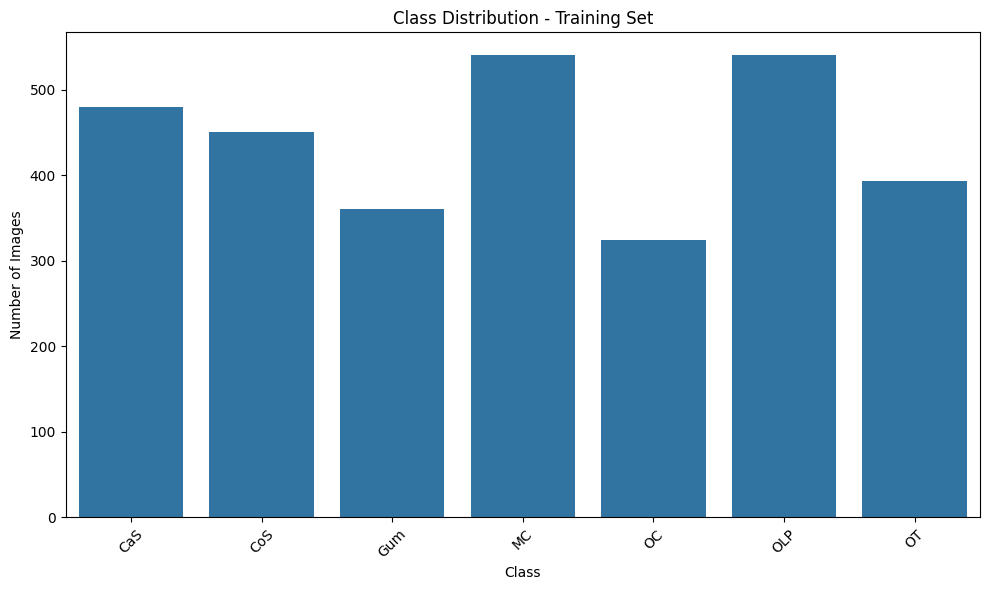

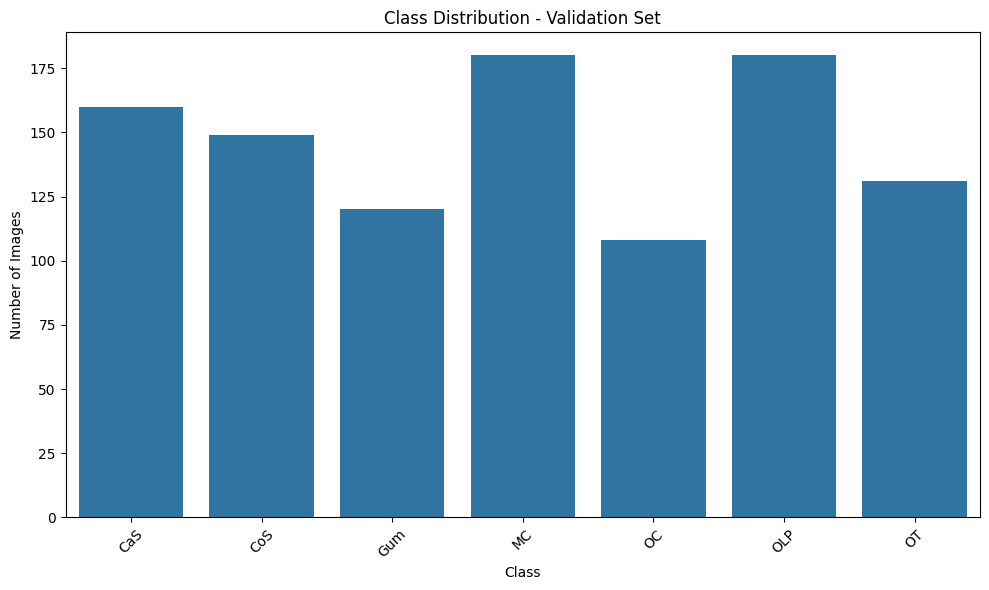

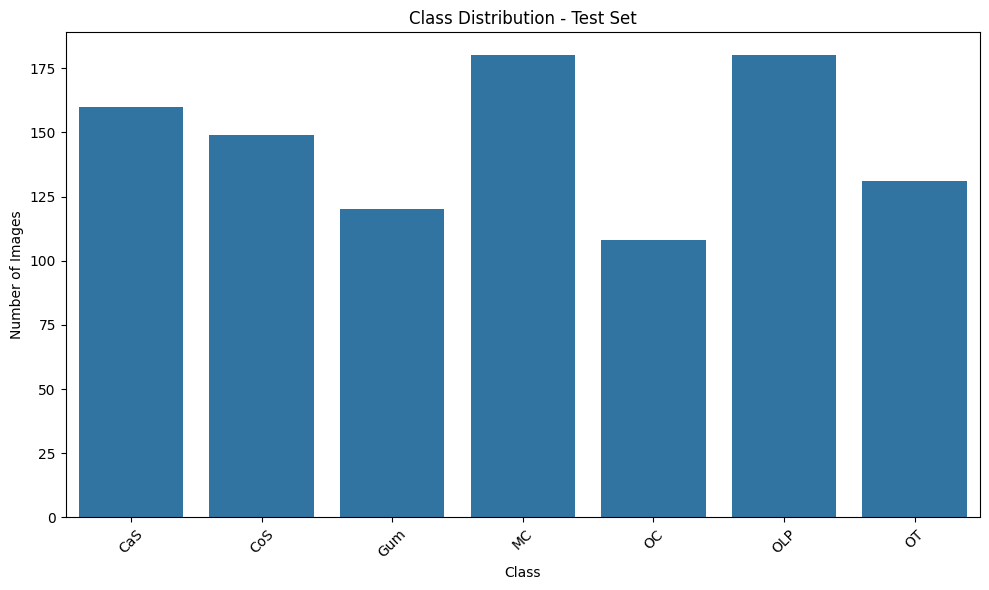

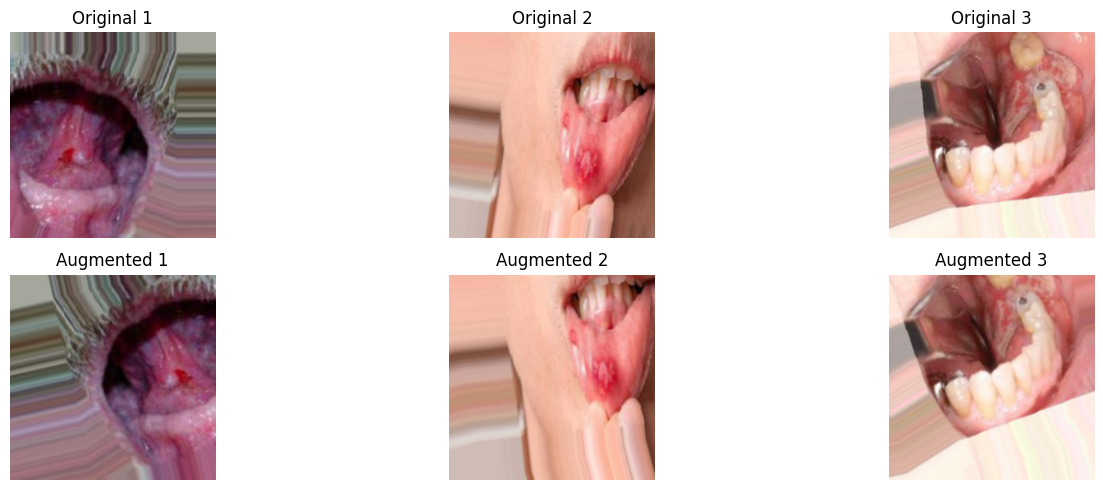

In [7]:
# Function to visualize class distribution
def plot_class_distribution(directory, title):
    counts = count_images(directory)
    plt.figure(figsize=(10, 6))
    sns.barplot(x=list(counts.keys()), y=list(counts.values()))
    plt.title(f'Class Distribution - {title}')
    plt.xlabel('Class')
    plt.ylabel('Number of Images')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Plot distributions
plot_class_distribution(train_dir, 'Training Set')
plot_class_distribution(valid_dir, 'Validation Set')
plot_class_distribution(test_dir, 'Test Set')

# Visualize sample images with augmentation
def show_augmented_images():
    # Get a batch of images
    x, y = next(train_generator)

    # Plot original and augmented images
    plt.figure(figsize=(15, 5))
    for i in range(3):
        # Original image
        plt.subplot(2, 3, i+1)
        plt.imshow(x[i])
        plt.title(f'Original {i+1}')
        plt.axis('off')

        # Augmented image
        plt.subplot(2, 3, i+4)
        aug_img = train_datagen.random_transform(x[i])
        plt.imshow(aug_img)
        plt.title(f'Augmented {i+1}')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

show_augmented_images()

In [8]:
def create_model():
    model = models.Sequential([
        # First Convolutional Block
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3)),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),

        # Second Convolutional Block
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),

        # Third Convolutional Block
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),

        # Dense Layers
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(len(CLASS_NAMES), activation='softmax')
    ])

    return model

# Create and compile model
model = create_model()
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Display model summary
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 222, 222, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 109, 109, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 109, 109, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 52, 52, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 52, 52, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 26, 26, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 86528)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │      11,075,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 7)                   │             903 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 11,170,759 (42.61 MB)

 Trainable params: 11,170,311 (42.61 MB)

 Non-trainable params: 448 (1.75 KB)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 10s/step - accuracy: 0.1723 - loss: 10.5019 

97/97 ━━━━━━━━━━━━━━━━━━━━ 1287s 13s/step - accuracy: 0.1724 - loss: 10.4520 - val_accuracy: 0.1673 - val_loss: 9.5093
Epoch 2/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 659s 6s/step - accuracy: 0.2071 - loss: 1.9386 - val_accuracy: 0.1605 - val_loss: 7.7291
Epoch 3/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 599s 6s/step - accuracy: 0.1834 - loss: 1.9482 - val_accuracy: 0.1605 - val_loss: 5.5512
Epoch 4/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.1962 - loss: 1.9886

97/97 ━━━━━━━━━━━━━━━━━━━━ 601s 6s/step - accuracy: 0.1962 - loss: 1.9885 - val_accuracy: 0.1897 - val_loss: 2.8203
Epoch 5/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 599s 6s/step - accuracy: 0.1886 - loss: 2.0043 - val_accuracy: 0.1333 - val_loss: 26.4301
Epoch 6/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.1877 - loss: 1.9654

97/97 ━━━━━━━━━━━━━━━━━━━━ 620s 6s/step - accuracy: 0.1878 - loss: 1.9651 - val_accuracy: 0.2870 - val_loss: 1.9560
Epoch 7/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 612s 6s/step - accuracy: 0.2187 - loss: 1.9112 - val_accuracy: 0.2364 - val_loss: 1.9898
Epoch 8/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 620s 6s/step - accuracy: 0.1816 - loss: 1.9290 - val_accuracy: 0.1994 - val_loss: 1.8947
Epoch 9/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 621s 6s/step - accuracy: 0.2061 - loss: 1.9135 - val_accuracy: 0.1770 - val_loss: 1.9287
Epoch 10/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 607s 6s/step - accuracy: 0.1911 - loss: 2.0165 - val_accuracy: 0.1868 - val_loss: 1.9901
Epoch 11/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 608s 6s/step - accuracy: 0.2143 - loss: 1.9339 - val_accuracy: 0.1702 - val_loss: 9.2618


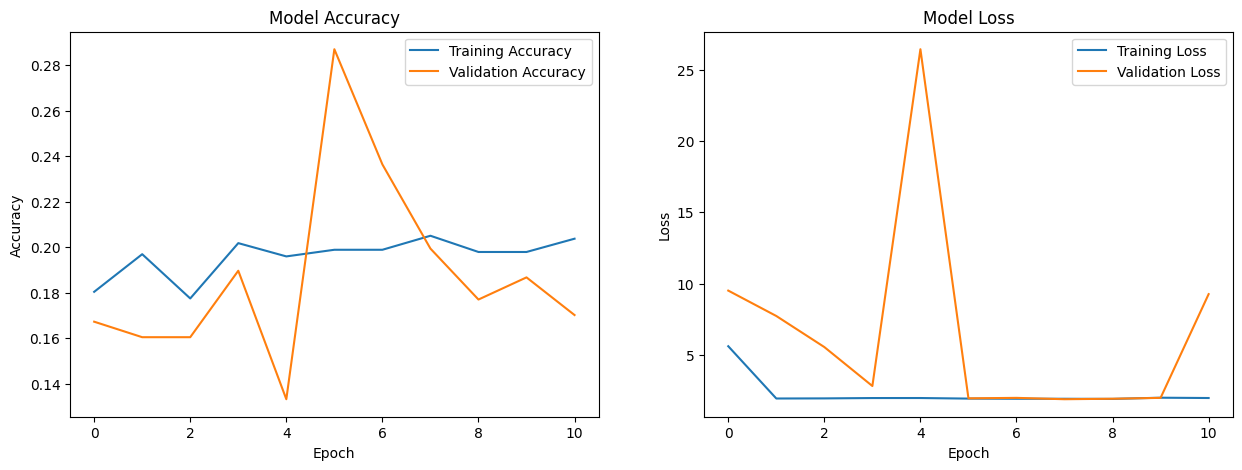

In [9]:
# Define callbacks
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=3,
        restore_best_weights=True
    ),
    tf.keras.callbacks.ModelCheckpoint(
        'best_model.h5',
        monitor='val_accuracy',
        save_best_only=True
    )
]

# Train the model
history = model.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=20,
    callbacks=callbacks
)

# Plot training history
def plot_training_history(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # Accuracy plot
    ax1.plot(history.history['accuracy'], label='Training Accuracy')
    ax1.plot(history.history['val_accuracy'], label='Validation Accuracy')
    ax1.set_title('Model Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.legend()

    # Loss plot
    ax2.plot(history.history['loss'], label='Training Loss')
    ax2.plot(history.history['val_loss'], label='Validation Loss')
    ax2.set_title('Model Loss')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.legend()

    plt.show()

plot_training_history(history)